### 判别器损失函数定义
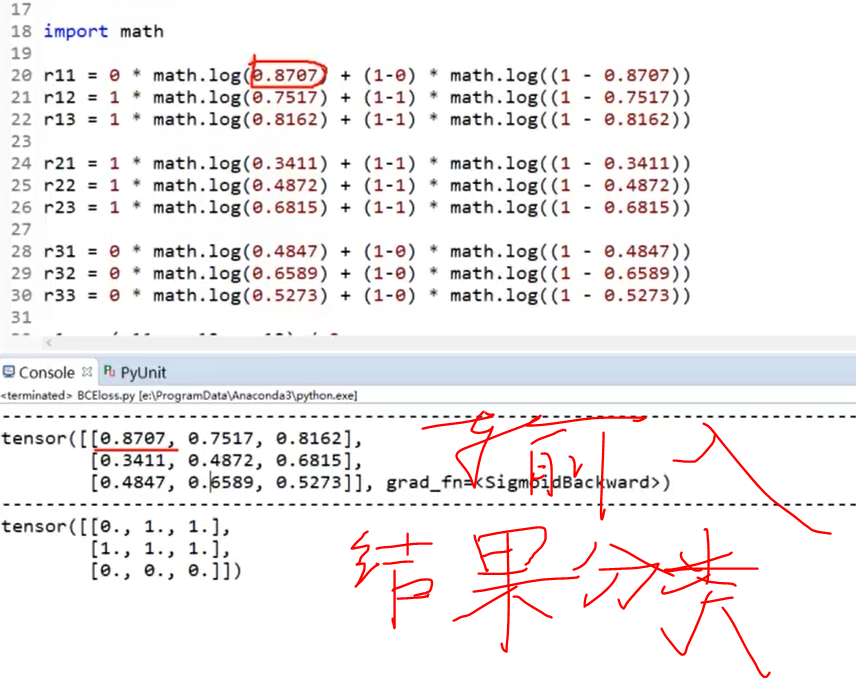

### 对抗生成网络让错误的sigmoid越小，越被判别错误，正确的sigmoid越大，越被判别正确

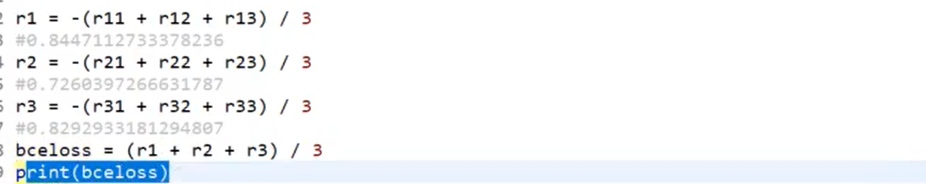

In [1]:
import torch 
from torch import autograd
from torch import nn
import torchvision
from torchvision.utils import save_image
from torch.autograd import Variable

In [2]:
inputs = autograd.Variable(torch.tensor([[ 1.9072,  1.1079,  1.4906],
        [-0.6584, -0.0512,  0.7608],
        [-0.0614,  0.6583,  0.1095]]), requires_grad=True)
print(inputs)
target = torch.FloatTensor([[0, 1, 1], [1, 1, 1], [0, 0, 0]])

tensor([[ 1.9072,  1.1079,  1.4906],
        [-0.6584, -0.0512,  0.7608],
        [-0.0614,  0.6583,  0.1095]], requires_grad=True)


In [3]:
m = nn.Sigmoid()
print(m(inputs))

tensor([[0.8707, 0.7517, 0.8162],
        [0.3411, 0.4872, 0.6815],
        [0.4847, 0.6589, 0.5273]], grad_fn=<SigmoidBackward>)


In [4]:
loss = nn.BCELoss()
print(loss(m(inputs), target))

tensor(0.8000, grad_fn=<BinaryCrossEntropyBackward>)


In [5]:
loss = nn.BCEWithLogitsLoss()
print(loss(inputs, target))

tensor(0.8000, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


In [6]:
#加载数字图像数据
dataset = torchvision.datasets.MNIST(root=r'C:\Users\刘东楷\mnist', #此处为自己定义的下载存在目录
                                     train=True#返回训练集
                                     ,download=False
                                     ,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()
                                                                                ,torchvision.transforms.Normalize((0.1307,), (0.3081, ))]))#自定义转换方式
data_loader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

In [7]:
### 生成器
class Generate(nn.Module):
    def __init__(self):
        super(Generate,self).__init__()
    
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1000),
            nn.BatchNorm1d(1000, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 784),
            nn.Tanh()
        )
    def forward(self,inputs):
        img = inputs.reshape(inputs.size(0), -1)
        img = self.model(inputs)
        img = img.view(inputs.size(0),28,28,1)
        return img
### 判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0),-1)
        validity = self.model(img_flat)
        return validity

In [8]:
model_g=Generate()
model_d=Discriminator()
model_g=model_g.cuda()
model_d=model_d.cuda()
loss=nn.BCELoss()
loss=loss.cuda()
optimiter = torch.optim.Adam(model_g.parameters(),lr=0.0002)
optimiter_ = torch.optim.Adam(model_d.parameters(),lr=0.0002)

In [9]:
def datas(n):
    data = torch.randn(n,100) #随机生成64行100列的数据
    return data

In [10]:
if __name__ =='__main__':
       for epoch in range(10):
            for i,(input_img,output_img) in enumerate(data_loader):
                l = torch.ones(input_img.size(0)).cuda()
                f = torch.zeros(input_img.size(0)).cuda()
                l = l.reshape(l.size(0), -1)
                f = f.reshape(f.size(0), -1)
                
                input_img=input_img.cuda()
                output_img=output_img.cuda()
                     
#生成器   
                for k in range(3):
                    Ge=model_g(datas(input_img.size(0)).cuda())
                    De=model_d(Ge)
                    loss_g = loss(De,l)
                    optimiter.zero_grad()
                    loss_g.backward()
                    optimiter.step()
            

#判别器
                De_1=model_d(input_img)
                Ge_1=model_g(datas(input_img.size(0)).cuda())
                De_2=model_d(Ge_1)
                loss_d_1 = loss(De_1,l)
                loss_d_2 = loss(De_2,f)
                loss_d = (loss_d_1+loss_d_2)/2
                optimiter_.zero_grad()
                loss_d.backward()
                optimiter_.step()
                
                if i % 100 == 0:
                    print(loss_g.item()/input_img.size(0),loss_d.item()/input_img.size(0))

0.01119239442050457 0.010820094496011734
0.02374441921710968 0.010256879031658173
0.015468873083591461 0.009728968143463135
0.013326148502528667 0.009530382230877876
0.011723577976226807 0.009460976347327232
0.022709988057613373 0.007946900092065334
0.010280083864927292 0.010275271721184254
0.023755162954330444 0.009733347222208977
0.01945994794368744 0.0075248051434755325
0.023094315081834793 0.00829804502427578
0.01491503044962883 0.008922917768359184
0.026051215827465057 0.006919685751199722
0.01770399510860443 0.007657916750758886
0.019786454737186432 0.008457975462079048
0.020264646038413048 0.006571644451469183
0.019615663215517998 0.006791171617805958
0.019723109900951385 0.009309082292020321
0.023222383111715317 0.008723657578229904
0.01695145294070244 0.00991232693195343
0.01565251499414444 0.008773691952228546
0.01824679598212242 0.007044724188745022
0.02193458192050457 0.0067442636936903
0.024865221232175827 0.007602538447827101
0.02035561203956604 0.006784116383641958
0.025

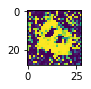

In [17]:
data_img_n = model_g(datas(64).cuda())
data_img_n.required_grad=False
import matplotlib.pyplot as plt 
plt.figure(figsize=(1,1))
plt.imshow(data_img_n[7].cpu().data.numpy().reshape(28,28))
plt.show()

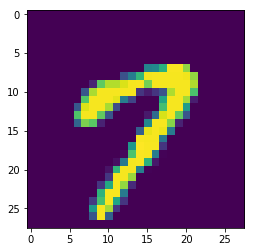

In [25]:
i,j = dataset[15]
plt.imshow(i.cpu().data.numpy().reshape(28,28))

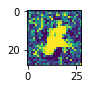

In [23]:
data_img_n = G(torch.randn((32, 784)).cuda())
data_img_n.required_grad=False
import matplotlib.pyplot as plt 
plt.figure(figsize=(1,1))
plt.imshow(data_img_n[13].cpu().data.numpy().reshape(28,28))
plt.show()

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from torchvision.utils import save_image
import matplotlib.pyplot as plt
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081, ))
    ])
train_dataset = datasets.MNIST(
        root=r'C:\Users\刘东楷\mnist',
        train=True,
        download=False,
        transform=transform
        )
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 784)
        )
        # self.l1 = torch.nn.Linear(784, )
        # self.l2 = torch.nn.Linear()
        # self.l3 = torch.nn.Linear()
    def forward(self, x): #x为一个张量 最终得到一个图片的张量
        x = x.reshape(x.size(0), -1)
        x = self.layer1(x)
        return x

class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.layer1(x)
        return x

G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
d_optomizer = optim.Adam(D.parameters(), lr=0.0003)
g_optomizer = optim.Adam(G.parameters(), lr=0.0003)

d_loss_train = []
g_loss_train = []
x = []
def train(epoch):
    for i, (input, target) in enumerate(train_loader):
        num_img = input.size(0)
        real_label = torch.ones(num_img)
        fake_label = torch.zeros(num_img)



        #训练D，判别器

        real_label = real_label.reshape(real_label.size(0), -1)
        fake_label = fake_label.reshape(fake_label.size(0), -1)

        real_out = D(input)
        d_loss_real = criterion(real_out, real_label)
        real_score = real_out

        z = torch.randn((num_img, 100))
        fake_img = G(z)
        fake_out = D(fake_img)
        d_loss_fake = criterion(fake_out, fake_label)

        d_loss = d_loss_fake + d_loss_real
        d_optomizer.zero_grad()
        d_loss.backward()
        d_optomizer.step()

        #训练生成器
        z = torch.randn(num_img, 100)
        fake_img = G(z)
        output = D(fake_img)
        g_loss = criterion(output, real_label)

        g_optomizer.zero_grad()
        g_loss.backward()
        g_optomizer.step()


        g_loss_train.append(g_loss.item() / num_img)
        d_loss_train.append(d_loss.item() / num_img)
        x.append(i)



        if i % 5 == 0:

            print(g_loss.item() / num_img, d_loss.item() / num_img)

for i in range(5):
    train(1)

0.022159289568662643 0.04441545158624649
0.021736806258559227 0.03862564638257027
0.020263375714421272 0.032323069870471954
0.01605628989636898 0.031503595411777496
0.013931306079030037 0.03709247335791588
0.01669149473309517 0.03471843898296356
0.02316262759268284 0.029973255470395088
0.030949179083108902 0.023380661383271217
0.04081626981496811 0.018517397344112396
0.049728188663721085 0.018251020461320877
0.05129845440387726 0.02283337339758873
0.03680797666311264 0.037663307040929794
0.04223344475030899 0.045308757573366165
0.06280799210071564 0.01439045462757349
0.08132114261388779 0.004819345194846392
0.07405813783407211 0.004757089074701071
0.060486700385808945 0.007416263222694397
0.05487379431724548 0.010303325019776821
0.0530351884663105 0.01137033011764288
0.05496073514223099 0.008263911120593548
0.05785290151834488 0.007058966439217329
0.056479454040527344 0.007264216896146536
0.050052449107170105 0.009732796810567379
0.03936239704489708 0.013273472897708416
0.0437716096639

0.21415241062641144 0.0004437495954334736
0.21276980638504028 0.0008552841027267277
0.2106335461139679 0.00019108080596197397
0.18345099687576294 0.0026506681460887194
0.255086749792099 0.013135507702827454
0.18964393436908722 0.0006427683401852846
0.22048041224479675 0.0010011658305302262
0.2660512328147888 4.7121116949710995e-05
0.2583985924720764 1.6914653315325268e-05
0.24885699152946472 0.0024782067630439997
0.2123839110136032 9.065625636139885e-05
0.1806545853614807 0.0020344413351267576
0.21699678897857666 0.00020030482846777886
0.2362305372953415 0.000325586850522086
0.2169645130634308 0.0002590669027995318
0.19581948220729828 0.00012369190517347306
0.21354541182518005 0.003615912515670061
0.1963057816028595 0.0005149035132490098
0.21253842115402222 0.00012157829769421369
0.20413312315940857 0.0005674394778907299
0.17944233119487762 9.596826566848904e-05
0.16830337047576904 0.0022425425704568624
0.2546164393424988 0.004801011178642511
0.2240169197320938 0.0005199054139666259
0.

0.2437399923801422 0.009121255949139595
0.18624192476272583 0.0024143196642398834
0.24997493624687195 0.00028260680846869946
0.20355914533138275 0.0015719927614554763
0.2191789597272873 0.00020171781943645328
0.20057174563407898 0.0011015792842954397
0.1892869472503662 0.0031823785975575447
0.23105546832084656 0.0011630195658653975
0.24526235461235046 0.007006121799349785
0.2495710849761963 0.0011555758537724614
0.2980278432369232 0.006981577258557081
0.43507522344589233 5.362957017496228e-05
0.37831351161003113 2.1427365936688147e-05
0.33141952753067017 2.357642188144382e-05
0.2601355016231537 0.00048818072536960244
0.28855612874031067 0.0004152639303356409
0.25670871138572693 0.0015336999204009771
0.2528805136680603 0.00011542229913175106
0.2561185359954834 0.0033878679387271404
0.21068075299263 0.0012863887241110206
0.27455922961235046 9.954161214409396e-05
0.2678043842315674 0.0009334028582088649
0.21151554584503174 0.0008820305811241269
0.2479429990053177 0.006215856410562992
0.27

0.20197638869285583 0.001422734116204083
0.20533424615859985 0.004198536742478609
0.1620636135339737 0.0010119560174643993
0.20245999097824097 0.0030464257579296827
0.24112725257873535 0.0015992041444405913
0.21198806166648865 0.0005665330099873245
0.22278988361358643 0.014327001757919788
0.16402579843997955 0.0022717625834047794
0.23725111782550812 0.008402621373534203
0.1887148916721344 0.00436863349750638
0.2133881151676178 0.0010218411916866899
0.19980576634407043 0.0021841193083673716
0.15562087297439575 0.001522895647212863
0.2546493113040924 0.006297698710113764
0.15973779559135437 0.004000664222985506
0.2535930275917053 0.0007211909396573901
0.19334100186824799 0.0014935393119230866
0.22645942866802216 0.0054429881274700165
0.24917151033878326 0.0006625417154282331
0.2069910168647766 0.006920130457729101
0.22100280225276947 0.0029051725286990404
0.25582414865493774 0.003185167908668518
0.24020548164844513 0.0006274145562201738
0.17614716291427612 0.01351554412394762
0.218087002

0.20642295479774475 0.0005374553147703409
0.21055538952350616 0.007522936910390854
0.18920615315437317 0.0007047487306408584
0.19993866980075836 0.0020599665585905313
0.24233175814151764 0.011334080249071121
0.15051773190498352 0.004865098744630814
0.20757925510406494 0.0019435673020780087
0.22774970531463623 0.001170888775959611
0.19683986902236938 0.0016275030793622136
0.24072566628456116 0.008176957257091999
0.1279750019311905 0.003938490990549326
0.23490379750728607 0.013730323873460293
0.14297416806221008 0.002416695700958371
0.216575488448143 0.01580902747809887
0.20430874824523926 0.0041147093288600445
0.1514914333820343 0.006263816263526678
0.24733112752437592 0.00026479113148525357
0.22456251084804535 0.009124738164246082
0.15604877471923828 0.003918462432920933
0.1931762993335724 0.007243998348712921
0.19193118810653687 0.006031231489032507
0.2284100502729416 0.009495179168879986
0.15311886370182037 0.004470334388315678
0.20046299695968628 0.0069443234242498875
0.176752358675

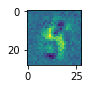

In [7]:
data_img_n = G(torch.randn((32, 100)))
data_img_n.required_grad=False
import matplotlib.pyplot as plt 
plt.figure(figsize=(1,1))
plt.imshow(data_img_n[13].cpu().data.numpy().reshape(28,28))
plt.show()

### 风格迁移,非对抗

In [30]:
import torch
import torchvision
from torchvision import transforms, models
from PIL import  Image
import matplotlib.pyplot as plt
from torch.autograd import Variable
import copy

In [31]:
transform = transforms.Compose([transforms.Scale([224,224]),
                               transforms.ToTensor()])

def  loadimg(path = None):
    img = Image.open(path)
    img = transform(img)
    img = img.unsqueeze(0)
    return img
    
ToPIL = torchvision.transforms.ToPILImage()
    
def img_show(img, title = None):
    img = img.clone().cpu()
    img = img.view(3,224,224)
    img = ToPIL(img)

    if title is not None:
        plt.title(title)
    plt.imshow(img)

D:\cn\lib\site-packages\torchvision\transforms\transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [32]:
content_img = loadimg("7.jpg")
content_img = Variable(content_img).cuda()
style_img   = loadimg("10.jpg")
style_img   =  Variable(style_img).cuda()

In [33]:
print(style_img.size())

torch.Size([1, 3, 224, 224])


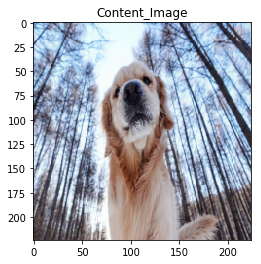

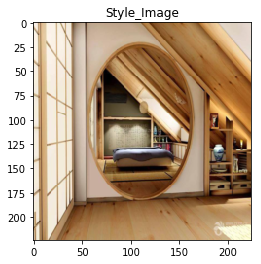

In [34]:
plt.figure()
img_show(content_img.data, title = "Content_Image")
plt.figure()
img_show(style_img.data, title = "Style_Image")

In [35]:
class Content_loss(torch.nn.Module):
    def __init__(self, weight, target):
        super(Content_loss, self).__init__()
        self.weight = weight
        self.target = target.detach()*weight #detach()函数可以返回一个完全相同的tensor,与旧的tensor共享内存，脱离计算图，不会牵扯梯度计算
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, input):
        self.loss = self.loss_fn(input*self.weight, self.target)
        self.output = input
        return self.output
        
    def backward(self):
        self.loss.backward(retain_graph = True)
        return self.loss

In [47]:
class gram_matrix(torch.nn.Module):
    def forward(self, input):
        a,b,c,d = input.size()
        feature = input.view(a*b, c*d)
        gram = torch.mm(feature, feature.t())
        return gram.div(a*b*c*d) #归一化，令所有gram参数和为1

In [48]:
class Style_loss(torch.nn.Module):
    def __init__(self, weight, target):
        super(Style_loss, self).__init__()
        self.weight = weight
        self.target = target.detach()*weight #detach()函数可以返回一个完全相同的tensor,与旧的tensor共享内存，脱离计算图，不会牵扯梯度计算
        self.loss_fn = torch.nn.MSELoss()
        self.gram = gram_matrix()
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight) #.mul_()点乘
        self.loss = self.loss_fn(self.G, self.target)
        return self.output
    def backward(self):
        self.loss.backward(retain_graph = True)
        return self.loss

定义需要优化的参数
迁移模型

In [49]:
use_gpu = torch.cuda.is_available()
cnn = models.vgg16(pretrained=True).features
if use_gpu:
    cnn = cnn.cuda()

In [50]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

构建自己的神经网络

In [51]:
content_layer = ["Conv_5","Conv_6"]

style_layer = ["Conv_1", "Conv_2", "Conv_3", "Conv_4", "Conv_5"]



content_losses = []
style_losses = []

conten_weight = 1
style_weight = 1000

new_model = torch.nn.Sequential()

model = copy.deepcopy(cnn)

gram = gram_matrix()

if use_gpu:
    new_model = new_model.cuda()
    gram = gram.cuda()

index = 1
for layer in list(model):
    if isinstance(layer, torch.nn.Conv2d): #layer 是否和torch.nn.Conv2d 模型一致
        name = "Conv_"+str(index)
        new_model.add_module(name, layer)
        if name in content_layer:
            target = new_model(content_img).clone()  #clone充当中间变量，会将梯度传给源张量进行叠加，但是本身不保存其grad，即值为None
            content_loss = Content_loss(conten_weight, target)
            new_model.add_module("content_loss_"+str(index), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layer:
            target = new_model(style_img).clone()
            target = gram(target)
            style_loss = Style_loss(style_weight, target)
            new_model.add_module("style_loss_"+str(index), style_loss)
            style_losses.append(style_loss)
            
    if isinstance(layer, torch.nn.ReLU):
        name = "Relu_"+str(index)
        new_model.add_module(name, layer)
        index = index+1
            
    if isinstance(layer, torch.nn.MaxPool2d):
        name = "MaxPool_"+str(index)
        new_model.add_module(name, layer)

print(new_model)

Sequential(
  (Conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_1): ReLU(inplace=True)
  (Conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_2): ReLU(inplace=True)
  (MaxPool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_3): ReLU(inplace=True)
  (Conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_4): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_4): ReLU(inplace=True)
  (MaxPool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_5): Conv2d(128, 256, k

In [12]:
input_img = content_img.clone()
parameter = torch.nn.Parameter(input_img.data)
optimizer = torch.optim.LBFGS([parameter])

In [13]:
content_losses

[Content_loss(
   (loss_fn): MSELoss()
 ), Content_loss(
   (loss_fn): MSELoss()
 )]

In [14]:
for i in style_losses:
    print(i)

Style_loss(
  (loss_fn): MSELoss()
  (gram): gram_matrix()
)
Style_loss(
  (loss_fn): MSELoss()
  (gram): gram_matrix()
)
Style_loss(
  (loss_fn): MSELoss()
  (gram): gram_matrix()
)
Style_loss(
  (loss_fn): MSELoss()
  (gram): gram_matrix()
)
Style_loss(
  (loss_fn): MSELoss()
  (gram): gram_matrix()
)


In [15]:
n_epoch = 1

run = [0]
while run[0] <= n_epoch:

    def closure():
        optimizer.zero_grad()
        style_score = 0
        content_score = 0
        parameter.data.clamp_(0,1) #压缩值到0-1
        new_model(parameter)
        
        for sl in style_losses:
            style_score += sl.backward()
        
        for cl in content_losses:
            content_score += cl.backward()
        
        run[0] += 1 


        return style_score+content_score
    


    optimizer.step(closure)

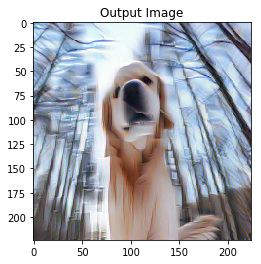

In [16]:
parameter.data.clamp_(0,1)
plt.figure()
img_show(parameter.data, title="Output Image")